In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import os
from random import seed
import pickle
import yaml
import imageio

from src.modules.vqvae import VQVae
from train_tokenizer import VQVAEModule
from src.dataset import Dataset
from IPython.display import Image, display
import matplotlib.pyplot as plt

/home/xabieririzar/liveportrait-tokenizer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pickle_dir = Path("dataset/pickles")

In [4]:
feats_enabled = {
    'kp': False,
    'velocity': False,
    'exp': True,
    'x_s': False,
    't': False,
    'R': False,
    'scale': False,
}

In [5]:
model_path = Path("outputs/20250513_203157-vae-exp-1024-codes-768-emb-depth4-lr1e-4-bs32-e300/checkpoints/checkpoint_epoch=289.ckpt")
pretrained = torch.load(model_path)

if model_path.suffix == '.ckpt':
    config_path = model_path.parent.parent / 'wandb' / 'latest-run' / 'files' / 'config.yaml'
else:
    config_path = model_path.parent / 'wandb' / 'latest-run' / 'files' / 'config.yaml'

config = yaml.safe_load(open(config_path, "r"))

vqvae = None
if model_path.suffix == '.ckpt':
    vqvae_module = VQVAEModule(vqvae_config=config["vqvae"]['value'], losses_config=config["losses"])
    vqvae_module.load_state_dict(pretrained['state_dict'])
    vqvae = vqvae_module.vqvae
    vqvae.to("cuda")
    vqvae.eval()
    print()
else:
    vqvae = VQVae(**config["vqvae"]['value'])
    vqvae.load_state_dict(pretrained)

vqvae.to("cuda")
vqvae.eval()
print()

In [22]:
ds = Dataset("dataset", split="eval", compute_stats=False)

Loading precomputed statistics from dataset/stats_all.pkl
Loaded feature-wise statistics successfully
Loaded 650 eval samples


### Prepare ds item

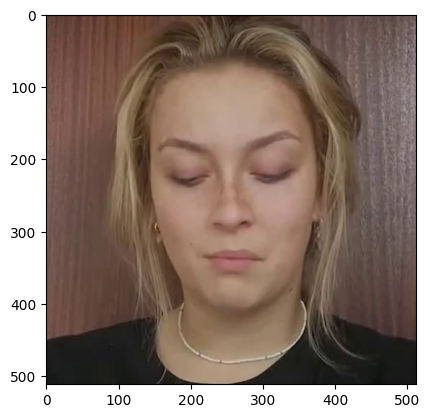

In [7]:
sample = ds[5]

pickle_path = sample['metadata']['pickle_path']
vid_id = pickle_path.split("/")[-1].split(".")[0]
vid_path = f"dataset/train/{vid_id}.mp4"

# Read the first frame from the video and display it
frame = imageio.get_reader(vid_path).get_data(0)
plt.imshow(frame)
plt.show()


In [8]:
frames = sample['kp'].shape[0]
fps = sample['metadata']['output_fps']
seq_len = min(sample['kp'].shape[0], 300)

# Initialize an empty tensor list to collect features
feature_tensors = []
dims = {}

if feats_enabled['kp']:
    print("Using kps")
    kps = sample['kp'][:seq_len].reshape(1, seq_len, -1)
    dims['kp'] = kps.shape[-1]
    feature_tensors.append(kps)

if feats_enabled['velocity']:
    print("Using velocity reg")
    vel = sample['velocity'][:seq_len].reshape(1, seq_len, -1)
    dims['velocity'] = vel.shape[-1]
    feature_tensors.append(vel)

if feats_enabled['exp']:
    print("Using exp")
    exps = sample['exp'][:seq_len].reshape(1, seq_len, -1)
    dims['exp'] = exps.shape[-1]
    feature_tensors.append(exps)

if feats_enabled['x_s']:
    print("Using x_s")
    x_s = sample['x_s'][:seq_len].reshape(1, seq_len, -1)
    dims['x_s'] = x_s.shape[-1]
    feature_tensors.append(x_s)

if feats_enabled['t']:
    print("Using t")
    t = sample['t'][:seq_len].reshape(1, seq_len, -1)
    dims['t'] = t.shape[-1]
    feature_tensors.append(t)

if feats_enabled['R']:
    print("Using R")
    R = sample['R'][:seq_len].reshape(1, seq_len, -1)
    dims['R'] = R.shape[-1]
    feature_tensors.append(R)

if feats_enabled['scale']:
    print("Using scale")
    scale = sample['scale'][:seq_len].reshape(1, seq_len, -1)
    dims['scale'] = scale.shape[-1]
    feature_tensors.append(scale)

# Concatenate all enabled features
if feature_tensors:
    features = torch.concat(feature_tensors, dim=2)
else:
    # Create an empty tensor if no features are enabled
    features = torch.empty((1, seq_len, 0))

features = features.to("cuda")
print("dims: ", dims)


Using exp
dims:  {'exp': 63}


### Reconstruct feats

In [9]:
# Load stats
stats = pickle.load(open("dataset/stats_all.pkl", "rb"))

In [10]:
# Send stats to GPU
for key in stats['mean']:
    stats['mean'][key] = stats['mean'][key].to("cuda")
    stats['std'][key] = stats['std'][key].to("cuda")
std = stats['std']
mean = stats['mean']

In [11]:
with torch.no_grad():
    reconstr, commit_loss, perplexity = vqvae(features)

In [12]:
# initialize empty array of shape N
filtered_dims = {k: v for k, v in dims.items() if k != 'velocity'}
total_dims = sum(filtered_dims.values())

new_reconstr = torch.zeros((*reconstr.shape[:-1], total_dims)) # 1, N_frames, dims

cur_ind = 0
reconstr_ind = 0
for feat, indices in dims.items():
    print(f"{feat} range: {cur_ind}:{cur_ind + indices}")
    if feat == 'velocity':
        # Skip velocity in new_reconstr but still increment reconstr_ind
        reconstr_ind += indices
        continue
    new_reconstr[:, :, cur_ind:cur_ind + indices] = reconstr[:, :, reconstr_ind:reconstr_ind + indices] * std[feat] + mean[feat]
    cur_ind += indices
    reconstr_ind += indices

exp range: 0:63


### Generate reconstructed pickle

In [13]:
filtered_dims

{'exp': 63}

In [14]:
# Prepare output
def repackage_output(original, reconstr, dataset, dims):
    # Get normalized tensors from reconstruction
    reconstr = reconstr.to('cpu').squeeze(0)
    frames = reconstr.shape[0]

    start = 0
    end = 0


    if feats_enabled['kp']:
        end += dims['kp']
        print(f"Kp: {start}:{end}")
        rec_kps = reconstr[:, start:end].reshape(-1, 1, 21, 3)
        start += dims['kp']

    if feats_enabled['exp']:
        end += dims['exp']
        print(f"Exp: {start}:{end}")
        rec_exps = reconstr[:, start:end].reshape(-1, 1, 21, 3)
        start += dims['exp']

    if feats_enabled['x_s']:
        end += dims['x_s']
        print(f"x_s: {start}:{end}")
        rec_x_s = reconstr[:, start:end].reshape(-1, 1, 21, 3)
        start += dims['x_s']

    if feats_enabled['t']:
        end += dims['t']
        print(f"t: {start}:{end}")
        rec_t = reconstr[:, start:end].reshape(-1, 1, 3)
        start += dims['t']

    if feats_enabled['R']:
        end += dims['R']
        print(f"R: {start}:{end}")
        rec_R = reconstr[:, start:end].reshape(-1, 3, 3)
        start += dims['R']

    if feats_enabled['scale']:
        end += dims['scale']
        print(f"scale: {start}:{end}")
        rec_scale = reconstr[:, start:end].reshape(-1, 1).squeeze(-1)
        start += dims['scale']
        
    
    # Denormalize original features too (since they come from __getitem__)
    orig_kps = dataset.denormalize_features(original['kp'], "kp")
    orig_exp = dataset.denormalize_features(original['exp'], "exp")
    orig_x_s = dataset.denormalize_features(original['x_s'], "x_s")
    orig_t = dataset.denormalize_features(original['t'], "t")
    orig_R = dataset.denormalize_features(original['R'], "R")
    orig_scale = dataset.denormalize_features(original['scale'], "scale").squeeze(-1)
    
    n_frames = min(original['metadata']['n_frames'], frames)

    output = {
        "n_frames": n_frames,
        "output_fps": original['metadata']['output_fps'],
        "motion": [
            {
                "kp": rec_kps[i].cpu().numpy() if feats_enabled['kp'] else orig_kps[i].cpu().numpy(),
                "exp": rec_exps[i].cpu().numpy() if feats_enabled['exp'] else orig_exp[i].cpu().numpy(),
                "x_s": rec_x_s[i].cpu().numpy() if feats_enabled['x_s'] else orig_x_s[i].cpu().numpy(),
                "t": rec_t[i].cpu().numpy() if feats_enabled['t'] else orig_t[i].cpu().numpy(),
                "R": rec_R[i].cpu().numpy() if feats_enabled['R'] else orig_R[i].cpu().numpy(),
                "scale": rec_scale[i].cpu().numpy() if feats_enabled['scale'] else orig_scale[i].cpu().numpy(),
            } for i in range(frames)
        ],
        "c_eyes_lst": [original['c_eyes_lst'][i].cpu().numpy() for i in range(len(original['c_eyes_lst']))],
        "c_lip_lst": [original['c_lip_lst'][i].cpu().numpy() for i in range(len(original['c_lip_lst']))],
    }
    return output

In [15]:
output = repackage_output(sample, new_reconstr, ds, dims=filtered_dims)

Exp: 0:63


In [16]:
video_id = Path(pickle_path).stem
new_path = pickle_dir / f"{video_id}_reconstructed.pkl"

with open(new_path, "wb") as f:
    pickle.dump(output, f)

In [17]:
import imageio

vid = imageio.get_reader(f"dataset/train/{video_id}.mp4")
frame = vid.get_data(0)

# save frame
imageio.imwrite("assets/examples/source/reconstructed.png", frame)

In [18]:
from src.modules.res_vqvae import ResVQVae

In [19]:
config['vqvae']

{'value': {'activation': 'relu',
  'apply_rotation_trick': False,
  'code_dim': 768,
  'code_num': 1024,
  'depth': 4,
  'dilation_growth_rate': 3,
  'down_t': 2,
  'nfeats': 63,
  'output_emb_width': 768,
  'stride_t': 2,
  'use_quantization': False,
  'width': 768}}

In [20]:
rvqvae = ResVQVae(**config['vqvae']['value']).to('cuda')
rvqvae.eval()

ResVQVae(
  (encoder): Encoder(
    (branch1): Sequential(
      (0): Conv1d(63, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Sequential(
        (0): Conv1d(768, 768, kernel_size=(4,), stride=(2,), padding=(1,))
        (1): Resnet1D(
          (model): Sequential(
            (0): ResConv1DBlock(
              (norm1): Identity()
              (norm2): Identity()
              (activation1): ReLU()
              (activation2): ReLU()
              (conv1): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(27,), dilation=(27,))
              (conv2): Conv1d(768, 768, kernel_size=(1,), stride=(1,))
            )
            (1): ResConv1DBlock(
              (norm1): Identity()
              (norm2): Identity()
              (activation1): ReLU()
              (activation2): ReLU()
              (conv1): Conv1d(768, 768, kernel_size=(3,), stride=(1,), padding=(9,), dilation=(9,))
              (conv2): Conv1d(768, 768, kernel_size=(1,), stride=(